# TBJ Question 2: Shortstop Defence

_by Eli Vigneron_


## Introduction

This notebook will accomplish the following task:

**Overall goal:**  
The goal here is to answer the question "which shortstop converted the most outs above average?". I will make use of the definition found on http://m.mlb.com/glossary/statcast/outs-aboveaverage#:~:text=Outs%20Above%20Average%20(OAA)%20is,and%20infielders%20(details%20below). A breif breakdown of the steps to be completed is as follows:

* Calculate how far the shortstop has to go to reach the ball this is refered to as the intercept point
* Calculate how much time the shortstop has to get to the intercept point
* Calculate how far the shortstop is from the base the runner is heading towards
* In the case of a forced play, estimate the time the shortstop has to throw the ball versus the time that the batter has to run to the base

Once these steps are completed, we will obtain a probability distribution for how often the shortstop will make an out. We can then assign a probability to each event, determine which ones count as reasonable opportunities and then add up the credit for each play made or not made per player to obtain a cumulative score viz. the outs above average.

## Dataset

Before beginning the analysis, we will load and view the dataset, and perform some initial cleaning.

* View the dataset info:

In [1]:
# load libraries

import pandas as pd
import math
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
import dask
import dask.dataframe as dd

ss_df = pd.read_excel("../input/short-stop/shortstopdefense.xlsx")
ss_df.head()

,id,playerid,pos,player_x,player_y,player_vx,player_vy,playtype,eventtype,trajectory,...,launch_speed,launch_spin_rate,launch_spin_axis,landing_location_radius,hang_time,landing_location_x,landing_location_y,runner_on_first,runner_on_second,runner_on_third
0,4151487,11742,6,-32.06643,146.6077,-0.687745,-1.066945,hit_into_play,field_out,G,...,89.19536,3818.099,187.9722,4.105553,0.038452,-1.159843,3.938315,False,False,False
1,4153376,9742,6,37.60806,149.1988,-0.315784,-0.161487,hit_into_play,field_out,G,...,38.30219,0.000,0.0000,4.167929,0.049439,-2.265474,3.498465,False,False,False
2,4153406,9742,6,-48.50450,126.2937,0.812922,-0.210266,hit_into_play,field_out,G,...,34.06448,0.000,0.0000,9.095510,0.148315,4.234459,8.049699,True,False,False
3,4153465,200265,6,-51.19549,141.4108,0.694964,-1.751723,hit_into_play,field_out,G,...,91.37302,0.000,0.0000,125.369400,1.055298,24.531730,122.945800,False,False,False
4,4152335,9425,6,-46.31368,138.7981,1.081192,0.055228,hit_into_play_no_out,single,G,...,87.29793,0.000,0.0000,11.827170,0.078735,-5.228023,10.608940,False,False,False


In [2]:
# drop some columns
ss_df.drop(['pos', 'id', 'trajectory'], axis=1, inplace=True)

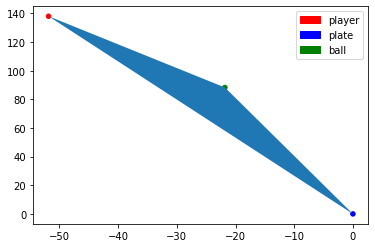

In [99]:
import matplotlib.patches as mpatches
# get a feel for where the player is and where the ball lands

# grab an event to look at
event = ss_df.iloc[[22]]

coords = event[['player_x', 'player_y', 'landing_location_x', 'landing_location_y']]
coords = np.array_split(coords.values, 2, axis=1)

X = np.array([np.array([0,0]), coords[0], coords[1]])
X = np.vstack(X)
Y = ['blue', 'red', 'green']

plt.scatter(X[:, 0], X[:, 1], s = 20, color = Y[:])

red_patch = mpatches.Patch(color='red', label='player')
green_patch = mpatches.Patch(color='green', label='ball')
blue_patch = mpatches.Patch(color='blue', label='plate')

plt.legend(handles=[red_patch, blue_patch, green_patch])

t1 = plt.Polygon(X[:3,:])
plt.gca().add_patch(t1)
plt.show()

## Can we solve the above triangle?

As a first step in the modelling process, we want to solve triangles such as the one above. As time progresses all the sides of the triangle will continue to shift. The player will be running to intercept the ball and the ball will be moving towards the outfield. The infielder has an unlimated number of paths to intercept the ball but in most cases would prefer to get there as quickly as possible to make the play. 

To simplify the motion of the ball and the fielder, we will make use of the following equations:
\begin{equation}
d_f = v_t(t - \frac{1}{c}(1-e^{-ct})), \enspace d_b=\frac{v_0}{k}(1-e^{-kt})
\end{equation}



Where the first equation represents a fielder at rest who increases to a max velocity. Here $d_f$ is the distance from the fielder to intercept point with the ball, $v_t$ is the maximum velocity. Since we do not have information for the max velocity of each short stop, we will assume a league average sprint speed of $27.1$ ft/s. $t$ is time and $c$ is the rate at which the fielder speeds up (estimated based on average league time to first base of $4.3$ s). 

The second equation represents a ball which slows down exponentially. Here $d_b$ is the distance to the ball from home plate, $v_0$ the initial velocity, $t$ time and $k$ is the rate at which the ball slows down (estimated based on ball with $80$ $v_0$ and $120$ ft in $2$ seconds).

We can relate all the given and neccessary quantities via the Law of Cosines. That is if we let $p$ denote the coordinates of the fielder and $\theta$ the angle between the ball vector and the player vector we have:

\begin{equation}
    d_f^2 = \Vert p \Vert^2 + d_b^2 - 2 \Vert p \Vert d_b cos(\theta) 
\end{equation}

The dataset provided as well as our basic estimates provides enough information to solve for the times when the curve representing the motion of the fielder intersects the curve representing the motion of the ball. We will solve this numerically using SymPy.

/opt/conda/lib/python3.7/site-packages/sympy/plotting/plot.py:1065: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  self.ax[i].spines['left'].set_smart_bounds(True)
/opt/conda/lib/python3.7/site-packages/sympy/plotting/plot.py:1066: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  self.ax[i].spines['bottom'].set_smart_bounds(False)


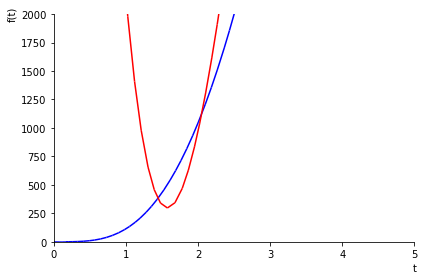

In [6]:
def dotproduct(v1, v2):
    return sum((a*b) for a, b in zip(v1, v2))


def length(v):
    return sqrt(dotproduct(v, v))


def angle(v1, v2):
    return acos(dotproduct(v1, v2) / (length(v1) * length(v2)))

plr = coords[0][0]
ball = coords[1][0]
theta = angle(plr, ball)
d_plr = np.linalg.norm(plr)
v_plr = 27.1   # average max sprint velocity for mlb player
c = 1.1        # rate at which player speeds up (estimated based on average time to fb)
k = 0.4        # rate at which ball slows (estimated based on ball with 80 v_0 and 120ft in 2 seconds)
v_ball =  event['launch_speed'].values[0] * 1.46667    # convert from mph to fps

var('t')
eq1 = (v_plr**2) * (t - (1/c) * ((1 - exp(-c*t))))**2
eq2 = d_plr**2 + (v_ball/k)**2 * (1-exp(-k*t))**2 - 2*d_plr * (v_ball/k) * (1-exp(-k*t))*cos(theta)

p = plot(eq1, (t, 0, 5), ylim=(-5, 2000), line_color='b', show=False)
p.extend(plot(eq2, (t, 0, 5), ylim=(-5, 2000), line_color='r', show=False))
p.show()

* Red represents the distance of the fielder from the ball, with the vertex of the parabola being the closest point to the fielder. The blue curve represents the motion of the fielder. The intercept(s) represents the times where the fielder can reach the ball. Note that the distances are squared since we are actually graphing the law of cosines equations.

In [12]:
import multiprocessing
def time_to_get_ball(player_coord, ball_coord, v_ball_mph):
    
    v_ball = v_ball_mph * 1.46667    # convert to ft/s
    player_coord = np.asarray(player_coord)
    ball_coord = np.asarray(ball_coord)
    theta = angle(player_coord, ball_coord)
    d_plr = np.linalg.norm(player_coord)
    t = Symbol('t')
    
    eq1 = (v_plr**2) * (t - (1/c) * ((1 - exp(-c*t))))**2
    eq2 = d_plr**2 + (v_ball/k)**2 * (1-exp(-k*t))**2 - 2*d_plr * (v_ball/k) * (1-exp(-k*t))*cos(theta)
    
    try:
        return nsolve((eq1-eq2), (t), (1))    # numerically solve for the t value
        
    except ValueError as e:
        return 1000                           # inf i.e. not possible


# compute the time to get to the intercept for each event   
dd_ss_df = dd.from_pandas(ss_df, npartitions=4*multiprocessing.cpu_count())\
             .map_partitions(lambda ss_df: ss_df.apply(lambda row: time_to_get_ball((row.player_x, row.player_y), 
                                                                                    (row.landing_location_x, 
                                                                                     row.landing_location_y), 
                                                                                     row.launch_speed), axis='columns'))\
             .compute(scheduler='processes')

dd_ss_df

0        1.34333851815556
1        5.11291304370071
2        4.70795483119057
3        8.69224139232284
4        1.46680642421701
               ...       
20146    1.19337004748871
20147                1000
20148    8.52760684155132
20149                1000
20150    6.74774257905941
Length: 20151, dtype: object

In [13]:
# add the column to our df
ss_df['op_time'] = dd_ss_df
ss_df

,playerid,player_x,player_y,player_vx,player_vy,playtype,eventtype,fielded_pos,fieldingplay,fielded_scoring,...,launch_spin_rate,launch_spin_axis,landing_location_radius,hang_time,landing_location_x,landing_location_y,runner_on_first,runner_on_second,runner_on_third,op_time
0,11742,-32.06643,146.6077,-0.687745,-1.066945,hit_into_play,field_out,6.0,63.0,f_assist,...,3818.099,187.9722,4.105553,0.038452,-1.159843,3.938315,False,False,False,1.34333851815556
1,9742,37.60806,149.1988,-0.315784,-0.161487,hit_into_play,field_out,5.0,53.0,f_assist,...,0.000,0.0000,4.167929,0.049439,-2.265474,3.498465,False,False,False,5.11291304370071
2,9742,-48.50450,126.2937,0.812922,-0.210266,hit_into_play,field_out,1.0,1.0,f_putout,...,0.000,0.0000,9.095510,0.148315,4.234459,8.049699,True,False,False,4.70795483119057
3,200265,-51.19549,141.4108,0.694964,-1.751723,hit_into_play,field_out,4.0,43.0,f_assist,...,0.000,0.0000,125.369400,1.055298,24.531730,122.945800,False,False,False,8.69224139232284
4,9425,-46.31368,138.7981,1.081192,0.055228,hit_into_play_no_out,single,6.0,6.0,f_fielded_ball,...,0.000,0.0000,11.827170,0.078735,-5.228023,10.608940,False,False,False,1.46680642421701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20146,161551,-29.76760,142.1196,-0.288299,-2.266879,hit_into_play,grounded_into_double_play,6.0,643.0,f_assist,...,0.000,0.0000,78.111140,0.560913,-22.276370,74.867310,True,True,True,1.19337004748871
20147,161551,-40.13431,141.5862,1.227215,-1.879390,hit_into_play_score,single,7.0,7.0,f_fielded_ball,...,0.000,0.0000,40.282080,0.276489,-17.734770,36.167990,True,True,True,1000
20148,167746,-44.43518,140.8206,1.409436,0.223796,hit_into_play,field_out,1.0,13.0,f_assist,...,0.000,0.0000,8.585034,0.053101,-0.536234,8.568271,False,False,False,8.52760684155132
20149,208314,-31.51937,135.2689,-0.459327,-0.998541,hit_into_play_no_out,single,1.0,1.0,f_fielded_ball,...,0.000,0.0000,11.819280,0.077515,0.810571,11.791450,True,False,False,1000


* Now we want to add an estimate for the time it will take to throw the ball to where it needs to be and make an out. We need the coordinates of the intercept point which can be found now that we have the estimated $t$ values. This can be done by first calculating $d_b$ and then use $\alpha$ (i.e the angle between the $x$-axis and the vector descrining the ball's position at the intercept point) to get the coordinates $(d_b \cos(\alpha), d_b(\sin(\alpha)))$. From here we can calculate the distance the ball needs to be thrown to reach the desired base. Once we have this distance we can use a simplified estimate to obtain the time it should take to throw the ball such a distance. Since we do not have data for each fielders throwing capacity we will assume a uniform velocity of $124$ f/s. As this is just a rough estimate we will assume that the ball travels uniformly in a straight line. Finally we can add this time to the opportunity time to arrive at an overall estimated time the fielder has to make the out.

In [15]:
first = (47.28, 76.58)
second = (0, 127)
third = (-47.28, 76.58)
home = (0, 0)

# distance to the ball
def d_b(t):
    return v_plr/k * (1-exp(-k * t))


# coordinates of the intercept
def intercept_coords(player_coord, ball_coord, op_time):
    alpha = atan2(ball_coord[1], ball_coord[0])
    db = d_b(op_time)
    return (db*cos(alpha), db*sin(alpha))


# basic distance between two points
def dist(p1, p2):
    return abs(sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[0])**2))


# case by case for where the ball should go
def time_to_toss(player_coord, ball_coord, fb, sb, tb, going, op_time):
    t = 0
    base = 100
    if not fb and not sb and not tb:    # no one on base, forced to first
        t = dist(intercept_coords(player_coord, ball_coord, op_time), first) / 124
        base = 1
        return t, base
    
    if fb and sb and not tb:            # forced to third
        t = dist(intercept_coords(player_coord, ball_coord, op_time), third) / 124
        base = 3
        return t, base
    
    if fb and sb and tb:                # forced to home
        t = dist(intercept_coords(player_coord, ball_coord, op_time), home) / 124
        base = 4
        return t, base
        
    if not going:
        t = dist(intercept_coords(player_coord, ball_coord, op_time), first) / 124
        base = 1
        return t, base
        
    if tb and going:
        t = dist(intercept_coords(player_coord, ball_coord, op_time), home) / 124
        base = 4
        return t, base
    
    if not tb:
        
        if fb and going:  # forced to second     
            t = dist(intercept_coords(player_coord, ball_coord, op_time), second) / 124
            base = 2
            return t, base

        if sb and going:      
            t = dist(intercept_coords(player_coord, ball_coord, op_time), third) / 124
            base = 3
            return t, base
        
    return t, base


ss_df['throw_time'], ss_df['base'] = zip(*ss_df.apply(lambda row: time_to_toss((row.player_x, row.player_y), 
                                                (row.landing_location_x, row.landing_location_y), 
                                                 row.runner_on_first, 
                                                 row.runner_on_second, 
                                                 row.runner_on_third, 
                                                 row.is_runnersgoing,
                                                 row.op_time), 
                                                 axis='columns'))
ss_df[['throw_time', 'base']]

,throw_time,base
0,0.814374300873771,1
1,1.08491409528789,1
2,0.434690979264702,1
3,0.584188328259015,1
4,0.874026923840006,1
...,...,...
20146,0.0836430461807524,4
20147,0.340185923349768,4
20148,0.771293223729358,1
20149,0.674344195509032,1


In [16]:
# compute the total optimal time to make a play
ss_df['total_time'] = ss_df['op_time'] + ss_df['throw_time']

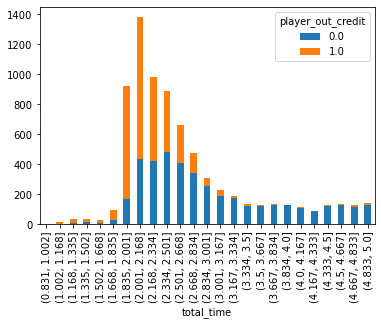

In [19]:
# create a histogram of the times

t_hist_df = ss_df[['base', 'player_out_credit', 'op_time', 'total_time']] 


# filter for times that are less than 5s since it is a conservative estimate to make it between bases 
t_hist_df = t_hist_df[ (t_hist_df['total_time'] < 5 )
          & (t_hist_df['total_time'] > 0 )]

t_hist_df = t_hist_df.astype(float)

bins = pd.crosstab(pd.cut(t_hist_df['total_time'], bins=25), t_hist_df['player_out_credit'])
bins.plot.bar(stacked=True)

In [20]:
# add a percent out column to the bins
bins['percent_out'] = bins[1.0] / (bins[0.0] + bins[1.0])
bins

player_out_credit,0.0,1.0,percent_out
total_time,,,
"(0.831, 1.002]",1,3,0.750000
"(1.002, 1.168]",1,12,0.923077
"(1.168, 1.335]",8,28,0.777778
"(1.335, 1.502]",13,20,0.606061
"(1.502, 1.668]",11,15,0.576923
"(1.668, 1.835]",29,66,0.694737
"(1.835, 2.001]",168,751,0.817193
"(2.001, 2.168]",435,945,0.684783
"(2.168, 2.334]",420,561,0.571865


In [39]:
import swifter

# now map the out probability back to each play by determining which interval 
# the total times fall into

bins.reset_index(level=0, inplace=True)

def get_percent(time):
    t = float(time)
    for k in range(25):
        if t in bins.iloc[k]['total_time']:
            return bins.iloc[k]['percent_out']
    return 0


ss_df['percent_out'] = ss_df['total_time'].swifter.apply(lambda row :  get_percent(row))

0    0.684783
1    0.000000
2    0.000000
3    0.000000
4    0.460674
Name: percent_out, dtype: float64

In [42]:
ss_df.head()

,playerid,player_x,player_y,player_vx,player_vy,playtype,eventtype,fielded_pos,fieldingplay,fielded_scoring,...,landing_location_x,landing_location_y,runner_on_first,runner_on_second,runner_on_third,op_time,throw_time,base,total_time,percent_out
0,11742,-32.06643,146.6077,-0.687745,-1.066945,hit_into_play,field_out,6.0,63.0,f_assist,...,-1.159843,3.938315,False,False,False,1.34333851815556,0.814374300873771,1,2.15771281902933,0.684783
1,9742,37.60806,149.1988,-0.315784,-0.161487,hit_into_play,field_out,5.0,53.0,f_assist,...,-2.265474,3.498465,False,False,False,5.11291304370071,1.08491409528789,1,6.19782713898861,0.000000
2,9742,-48.50450,126.2937,0.812922,-0.210266,hit_into_play,field_out,1.0,1.0,f_putout,...,4.234459,8.049699,True,False,False,4.70795483119057,0.434690979264702,1,5.14264581045527,0.000000
3,200265,-51.19549,141.4108,0.694964,-1.751723,hit_into_play,field_out,4.0,43.0,f_assist,...,24.531730,122.945800,False,False,False,8.69224139232284,0.584188328259015,1,9.27642972058185,0.000000
4,9425,-46.31368,138.7981,1.081192,0.055228,hit_into_play_no_out,single,6.0,6.0,f_fielded_ball,...,-5.228023,10.608940,False,False,False,1.46680642421701,0.874026923840006,1,2.34083334805702,0.460674


In [44]:
# create a leader board
oaa = ss_df[['playerid', 'percent_out', 'player_out_credit']]
oaa = oaa[oaa.percent_out != 0]    # drop zero prob plays

opportunities = oaa.groupby(['playerid']).count()    # count the number of opportunities
opportunities.rename(columns={'player_out_credit': 'opportunities'}, inplace=True)
opportunities.drop('percent_out', axis=1, inplace=True)

leader_board = oaa.groupby(['playerid','player_out_credit']).agg({'percent_out' : 'sum', 'player_out_credit' : 'sum'})
leader_board['oaa'] = leader_board['player_out_credit'] - leader_board['percent_out']
leader_board = leader_board.groupby(level=0).sum()
leader_board = pd.merge(leader_board, opportunities, left_index=True, right_index=True)
leader_board.drop(['percent_out', 'player_out_credit'], axis=1, inplace=True)

leader_board.sort_values(by=['oaa'], ascending=False).head(10)

,oaa,opportunities
playerid,,
5495,21.033841,231
154448,11.242981,254
5419,10.936109,193
11742,10.492946,217
206311,8.149647,193
162393,6.792641,219
9074,6.270207,205
2950,6.229709,175
159128,4.984077,45


## Summary Questions

1. I think that having information for the fielders max sprint speed would help since then I could factor it into the fielder equation. Information such as the launch angle and initial velocity of the thrown ball for each event might also help to obtain a more robust estimate of the times to throw the ball. I also think that perhaps data for the retrieval rates of each shortstop could be useful. More specifically by retrieval rate I mean if the vector of the batted ball was fixed to some tight range around the fielder at the start of a play, how often does he muff or deflect the ball versus make a clean catch. We could then multiply this percentage with the percent out percentage. I would have liked to obtain better estimates for $d_f$ as well as for $d_b$, I think I could have made better use of some of the information provided to get better estimates for these quantities. For example I think I could have used the spin rate and the launch angle of the ball off the bat to estimate $d_b$ better.


2. From a sort of 'soft' perspective I was surprised by how fielders are able to instinctively make these sorts of optimized calculations while playing. It is also interesting to note that these types of metrics can give insight into to 'quality' of a play. For example a play could visually look like a low pobability play when in actuality the data suggests it is a high probability play. From this one reasonable conclusion could be that the fielder took a suboptimal route to the ball. Despite using a relatively simplified model, we do seem to have captured a number of plays that a fielder makes / observes i.e. charging the ball, having the ball find a gap in the player position, making a routine out. It seems like some of this information could be used to suggest defensive shifts.  

## Appendix

For fun I ran some regressions to see how well we could predict outs.

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

ss_df_2 = pd.read_excel("../input/short-stop/shortstopdefense.xlsx")
ss_df_2.dropna(inplace=True)

# drop columns that are constant
ss_df_2.drop(['pos', 'id', 'trajectory'], axis=1, inplace=True)

# convert bools to ints
ss_df_2[["player_out_credit", "is_runnersgoing","is_bunt", "runner_on_first","runner_on_second","runner_on_third"]] \
= ss_df_2[["player_out_credit", "is_runnersgoing","is_bunt", "runner_on_first","runner_on_second","runner_on_third"]].astype(int)

ss_df_2['playtype'] = pd.factorize(ss_df_2.playtype)[0]
ss_df_2['eventtype'] = pd.factorize(ss_df_2.eventtype)[0]
ss_df_2['fielded_scoring'] = pd.factorize(ss_df_2.fielded_scoring)[0]

ss_df_cpy = ss_df_2.copy()
ss_df_cpy.drop('player_out_credit', axis=1, inplace=True)

# Split-out validation dataset
ss_array = ss_df_2.values
ss_array_2 = ss_df_cpy.values

X = ss_array_2     # array with the numeric variables
y = ss_array_2[:,10]      # array with the out variable

X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=1)

In [61]:
# Spot Check Algorithms
models = [('LR', LogisticRegression(solver='liblinear', multi_class='ovr')), ('LDA', LinearDiscriminantAnalysis()),
          ('KNN', KNeighborsClassifier()), ('CART', DecisionTreeClassifier()), ('NB', GaussianNB()),
          ('SVM', SVC(gamma='auto'))]

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LR: 0.983311 (0.000331)
LDA: 0.983497 (0.001984)
KNN: 0.983373 (0.000244)
CART: 1.000000 (0.000000)
NB: 0.981139 (0.002706)
SVM: 0.983373 (0.000244)


In [62]:
# Make predictions on validation dataset
model = LinearDiscriminantAnalysis()
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)

In [63]:
# Evaluate predictions
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.9818858560794045
[[3940   19]
 [  54   17]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      3959
         1.0       0.47      0.24      0.32        71

    accuracy                           0.98      4030
   macro avg       0.73      0.62      0.65      4030
weighted avg       0.98      0.98      0.98      4030



In [64]:
model.predict_proba(X_validation)

array([[9.99297924e-01, 7.02076058e-04],
       [9.99449495e-01, 5.50505034e-04],
       [9.99301531e-01, 6.98469023e-04],
       ...,
       [9.98573330e-01, 1.42667020e-03],
       [9.99353173e-01, 6.46827132e-04],
       [9.98698833e-01, 1.30116711e-03]])

## References


http://m.mlb.com/glossary/statcast/outs-above-average#:~:text=Outs%20Above%20Average%20(OAA)%20is,and%20infielders%20(details%20below).

http://tangotiger.com/images/uploads/History_of_the_Fielding.pdf

https://tht.fangraphs.com/the-physics-of-fielding-grounders/